In [13]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pycwt as wavelet
from pycwt.helpers import find
plt.style.use('classic')
import matplotlib.colors as colors

font = {'size'   : 22}
mpl.rc('font', **font)
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3

import datetime
def ns2date(timestamp): #nanosecond timestamp tp datetime
    return datetime.datetime.utcfromtimestamp(timestamp/1e9)

def ts2dates(date_array):
    return np.array([ns2date(date_array[i]) for i in range(len(date_array))])

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(plt.cm.viridis, 0.2, 1, n=100)

In [14]:
def get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title):
    result = {}
    #detrend and normalize data
    p = np.polyfit(t, dat, 1)
    dat_notrend = dat - t*p[0]
    std = np.std(dat_notrend)
    var = std ** 2  # Variance
    dat_norm = (dat_notrend - np.mean(dat))/std

    #wavelet transform
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

    #power spectra
    power = np.abs(wave)**2 / scales[:,None] # normalized by scales (Liu 2007)
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    #significance
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha, significance_level=0.95, wavelet=mother)

    signif = signif / scales #GIJS
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    #global wavelet spectrum
    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha, 
                                            significance_level=0.95, dof=dof, wavelet=mother)
    glbl_signif = glbl_signif / scales #GIJS
    
    result['dat'] = dat
    result['dat_norm'] = dat_norm
    result['power'] = power
    result['fft_power'] = fft_power
    result['period'] = period
    result['signif'] = signif
    result['fft_theor'] = fft_theor
    result['sig95'] = sig95
    result['glbl_power'] = glbl_power
    result['glbl_signif'] = glbl_signif
    result['coi'] = coi
    result['fftfreqs'] = fftfreqs
    result['var'] = var
    result['scales'] = scales
    result['wave'] = wave
    result['name'] = name
    result['title'] = title
    
    return result

def get_cross_wavelet(result1, result2, name, title):
    resultx = {}
    dat1 = result1['dat']
    dat2 = result2['dat']
    N = dat1.size
    W12, coi, freq, signif = wavelet.xwt(result1['dat_norm'], result2['dat_norm'], dt, dj, s0, J, 
                                         significance_level=0.95, wavelet='morlet', normalize=False)
    #if the coherence is to be calculated, sig should be set to sig=True.
    WCT, aWCT, coi, freq, sig = wavelet.wct(result1['dat_norm'], result2['dat_norm'], dt, dj, s0, int(J), 
                                            sig=False, significance_level=0.95, wavelet='morlet', normalize=False)
    angles = aWCT*180/np.pi
    sig95 = np.ones([1,N]) * signif[:,None]
    sig95 = np.abs(W12) / sig95
    sig95c = np.ones([1,N]) * sig[:,None]
    sig95c = WCT / sig95c
    
    resultx['period'] = result1['period']
    resultx['scales'] = result1['scales']
    resultx['W12'] = W12/resultx['scales'][:,None]
    resultx['coi'] = coi
    resultx['signif'] = signif/resultx['scales']
    resultx['WCT'] = WCT
    resultx['aWCT'] = aWCT
    resultx['sig'] = sig
    resultx['angles'] = angles
    resultx['sig95'] = sig95
    resultx['sig95c'] = sig95c
    resultx['name'] = name
    resultx['title'] = title
    
    return resultx

In [15]:
def plot_wavelet(timestamps, result, char='a', path='n'):
    """char: default='a', defines from which letter plots are labeled"""
    figprops = dict(figsize=(11, 8), dpi=72)
    fig = plt.figure(**figprops)

    t = ts2dates(timestamps).astype('datetime64[ns]')
    dt = int(np.diff(timestamps)[0])

    # First sub-plot, the original time series anomaly and inverse wavelet
    # transform.
    ax = plt.axes([0.1, 0.75, 0.65, 0.25])
    ax.plot(t, result['dat'], 'k', linewidth=1.5)
    ax.set_title('{0}) {1}'.format(char,result['title']), y=1.03)
    ax.set_ylabel(r'{}'.format(result['name']))
    ax.grid()
    Xticks = [datetime.datetime(yr, mth, 1) for mth in [1,4,7,10] for yr in range(2005,2016)]
    ax.set_xticks(Xticks)
    #ax.set_xticklabels(Xticks, rotation=25, ha='center')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.set_xlim([t[0] ,t[-1]])
    #ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), fontsize=20)

    # Second sub-plot, the normalized wavelet power spectrum and significance
    # level contour lines and cone of influece hatched area. Note that period
    # scale is logarithmic.
    bx = plt.axes([0.1, 0.3, 0.65, 0.35], sharex=ax)
    levels = [0.0625, 0.125, 0.25, 0.5, 1]
    bx.contourf(t, np.log2(result['period']), np.log2(result['power']), np.log2(levels),
                extend='both', cmap=plt.cm.viridis)
    extent = [t.min(), t.max(), 0, max(result['period'])]
    bx.contour(t, np.log2(result['period']), result['sig95'], [-99, 1], colors='k', linewidths=2,
               extent=extent)
    bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                               t[:1] - dt, t[:1] - dt]),
            np.concatenate([np.log2(result['coi']), [1e-9], np.log2(result['period'][-1:]),
                               np.log2(result['period'][-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    bx.set_title('{0}) Power Spectrum'.format( chr(ord(char)+1) ), y=1.03)
    bx.set_ylabel('Period (days)')
    bx.set_xlabel('Year')
    #
    Yticks = 2 ** np.arange(np.ceil(np.log2(result['period'].min())),
                               np.ceil(np.log2(result['period'].max()))).astype('int64')
    bx.set_yticks(np.log2(Yticks))
    bx.set_yticklabels(Yticks)
    plt.setp(bx.get_xticklabels(), rotation=25)

    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    cx = plt.axes([0.77, 0.3, 0.25, 0.35], sharey=bx)
    cx.plot(result['glbl_signif'], np.log2(result['period']), 'k--', zorder=9999)
    #cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
    #cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc', linewidth=1.)
    cx.plot(result['var'] * result['glbl_power'], np.log2(result['period']), 'k-', linewidth=1.5)
    cx.set_title('{0}) Global Spectrum'.format( chr(ord(char)+2) ), loc='center', y=1.03)
    cx.set_xlabel(r'Power')
    cx.set_xlim([0, result['glbl_power'].max() + result['var']])
    cx.set_ylim(np.log2([result['period'].min(), result['period'].max()]))
    cx.set_yticks(np.log2(Yticks))
    cx.set_yticklabels(Yticks)
    Xticks = cx.get_xticks()
    cx.set_xticks(Xticks[::2])
    cx.grid()
    plt.setp(cx.get_yticklabels(), visible=False)
    
    if path != 'n':
        plt.savefig(path, bbox_inches='tight')
        print('Figure saved as {}'.format(path))

def plot_cross_wavelet(timestamps, result1, result2, resultx, char='a', path='n'):
    figprops = dict(figsize=(11, 8), dpi=72)
    fig = plt.figure(**figprops)
    
    ts = ts2dates(timestamps).astype('datetime64[ns]')
    dts = int(np.diff(timestamps)[0])
    
    ax = plt.axes([0.1, 0.75, 0.65, 0.25])
    ax2 = ax.twinx()
    ax.plot(ts, result1['dat'], 'k', linewidth=1.5, zorder=1)
    ax2.plot(ts, result2['dat'], 'tab:blue', linewidth=1.5, zorder=2)
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    ax2.patch.set_visible(True)
    ax.tick_params(axis='y', labelcolor='k')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_ylabel(r'{}'.format(result1['name']), color='k')
    ax2.set_ylabel(r'{}'.format(result2['name']), color='tab:blue')
    ax.set_title('{0}) {1} and {2}'.format(char, result1['title'], result2['title']))
    ax.grid()
    Xticks = [datetime.datetime(yr, mth, 1) for mth in [1,4,7,10] for yr in range(2005,2016)]
    ax.set_xticks(Xticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.set_xlim([ts[0] ,ts[-1]])
    ylim = ax.get_ylim()[1]
    Yticks = np.arange(0,ylim,10)
    ax.set_yticks(Yticks)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    
    bx = plt.axes([0.1, 0.3, 0.65, 0.35], sharex=ax)
    levels = [0.0625, 0.125, 0.25]
    bx.contourf(ts, np.log2(resultx['period']), np.log2(np.abs(resultx['W12'])), np.log2(levels), extend='both', cmap=new_cmap)
    extent = [ts.min(), ts.max(), 0, max(resultx['period'])]
    bx.contour(ts, np.log2(resultx['period']), resultx['sig95'], [-99, 1], colors='k', linewidths=2, extent=extent)
    x,y = np.meshgrid(ts[::int(200/(dt/(12.42/24)))], resultx['period'][::2])
    ux = yx = np.ones_like(x.astype('float64'))
    bx.quiver(x, np.log2(y), ux, yx, angles=resultx['angles'][::2,::int(200/(dt/(12.42/24)))])
    bx.set_title('{0}) Cross Power Spectrum'.format( chr(ord(char)+1) ), y=1.03)
    bx.set_ylabel('Period (days)')

    bx.fill(np.concatenate([ts, ts[-1:] + dts, ts[-1:] + dts,
                               ts[:1] - dts, ts[:1] - dts]),
            np.concatenate([np.log2(resultx['coi']), [1e-9], np.log2(resultx['period'][-1:]),
                               np.log2(resultx['period'][-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    bx.set_ylim(np.log2([32, resultx['period'].max()]))
    Yticks = 2 ** np.arange(np.ceil(np.log2(32)),
                               np.ceil(np.log2(resultx['period'].max()))).astype('int64')
    bx.set_yticks(np.log2(Yticks))
    bx.set_yticklabels(Yticks)
    bx.set_xlabel('Year')
    plt.setp(bx.get_xticklabels(), rotation=25)

    #cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
    #cx.plot(resultx['signif'], np.log2(resultx['period']), 'k--', zorder=9999)
    #cx.plot(np.mean(np.abs(resultx['W12']),axis=1), np.log2(resultx['period']), 'k-', linewidth=1.5)
    #cx.set_title('c) Global Cross Wavelet Spectrum')
    #cx.set_xlabel(r'Power')
    #cx.set_ylim(np.log2([resultx['period'].min(), resultx['period'].max()]))
    #cx.set_yticks(np.log2(Yticks))
    #cx.set_yticklabels(Yticks)
    #cx.grid()
    #plt.setp(cx.get_yticklabels(), visible=False)

    if path!='n':
        plt.savefig(path, bbox_inches='tight')
        print('Figure saved as {}'.format(path))

# NINO EXAMPLE

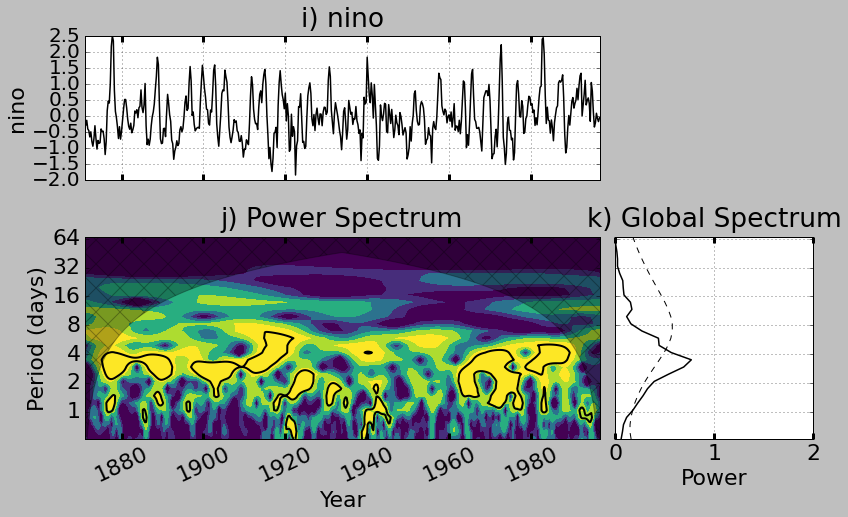

In [16]:
file = '../data/sst_nino3.txt'
name = 'nino'
title = 'nino'
dat = np.loadtxt(file)
N = dat.size
dt = 0.25
t = np.arange(0, N) * dt
timestamps = t*365.25*24*3600*1e9 + (datetime.datetime.timestamp(datetime.datetime(1871,1,1))+3600)*1e9

mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 7 / dj  # 7 powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)

plot_wavelet(timestamps, result, char='i', path='n')

# Wind

Figure saved as ../figures/pycwt/uwp_tidal.png


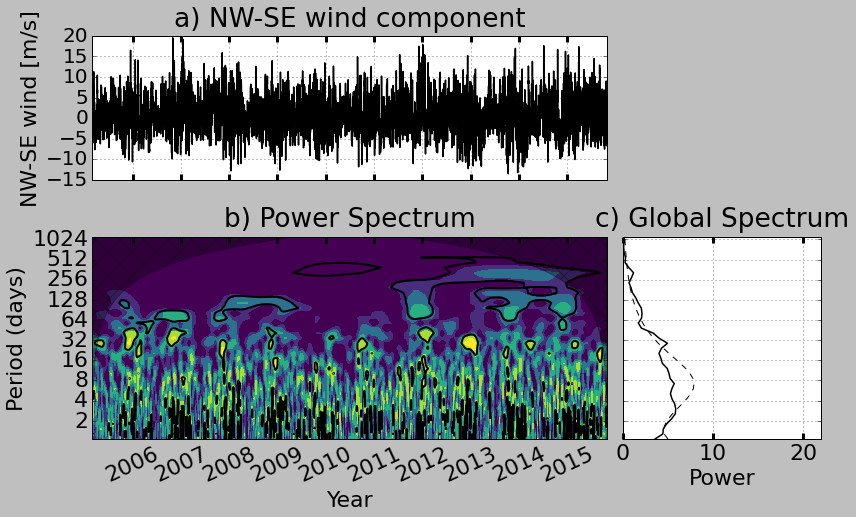

In [17]:
file = '../data/uwp_tidal.txt'
name = 'NW-SE wind [m/s]'
title = 'NW-SE wind component'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/vwp_tidal.png


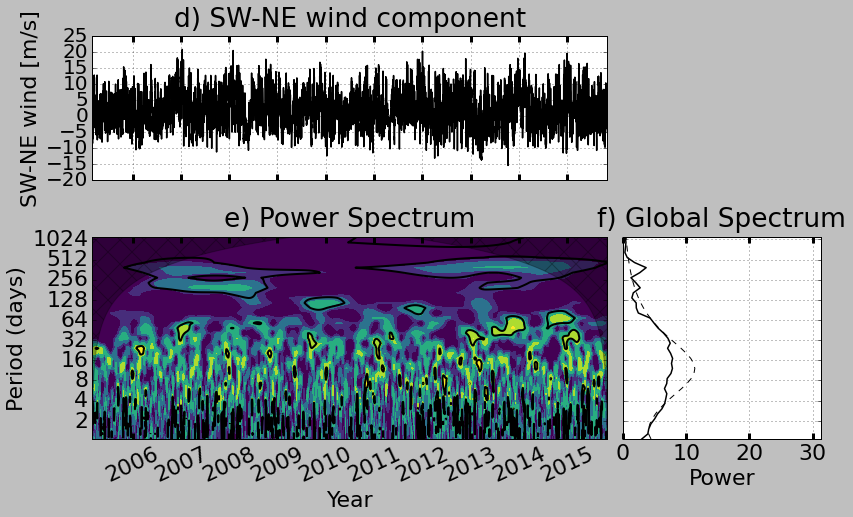

In [18]:
file = '../data/vwp_tidal.txt'
name = 'SW-NE wind [m/s]'
title = 'SW-NE wind component'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='d', path='../figures/pycwt/{}.png'.format(file[8:-4]))

# Flushing time

Figure saved as ../figures/pycwt/TF_DWS.png


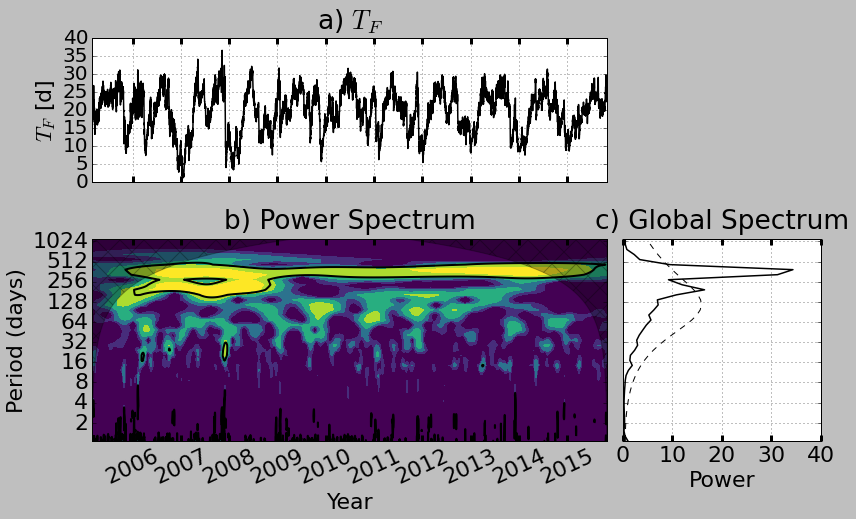

In [19]:
file = '../data/TF_DWS.txt'
name = '$T_F$ [d]'
title = '$T_F$'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/TF_WDWS.png


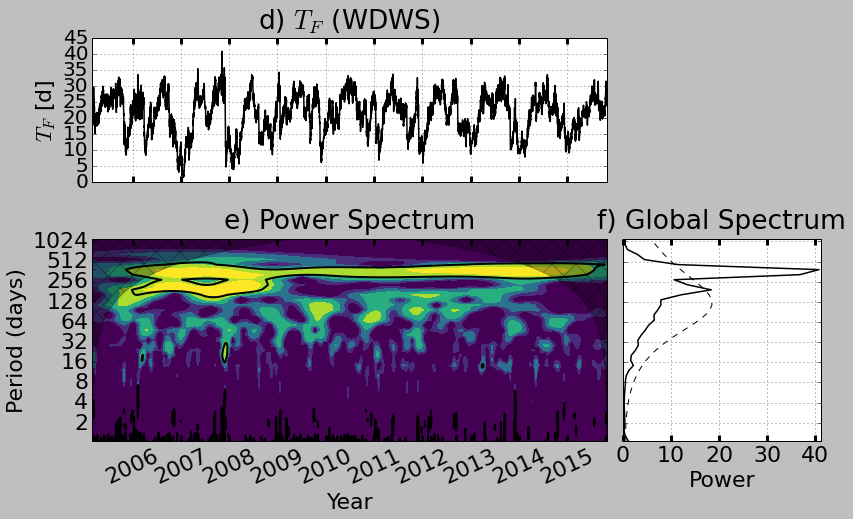

In [20]:
file = '../data/TF_WDWS.txt'
name = '$T_F$ [d]'
title = '$T_F$ (WDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='d', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/TF_EDWS.png


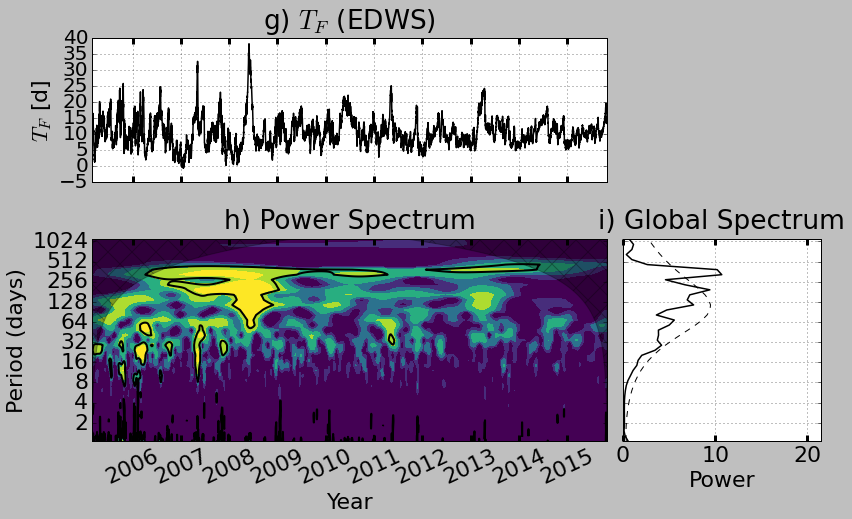

In [21]:
file = '../data/TF_EDWS.txt'
name = '$T_F$ [d]'
title = '$T_F$ (EDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='g', path='../figures/pycwt/{}.png'.format(file[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/TF_DWS_x_uwp_tidal.png


<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/TF_DWS_x_vwp_tidal.png


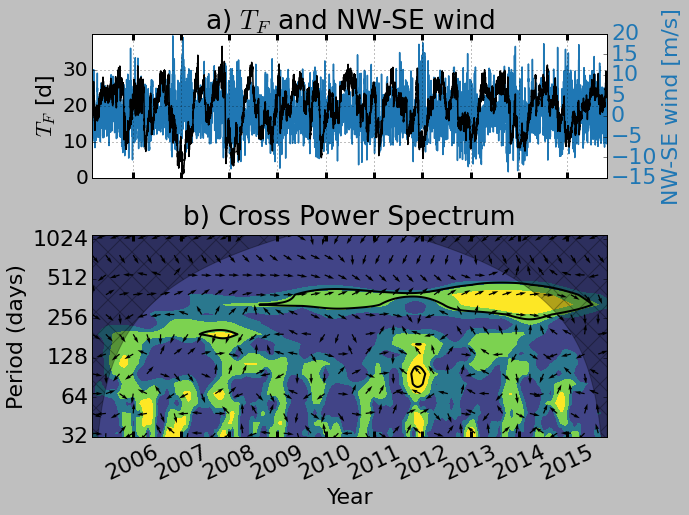

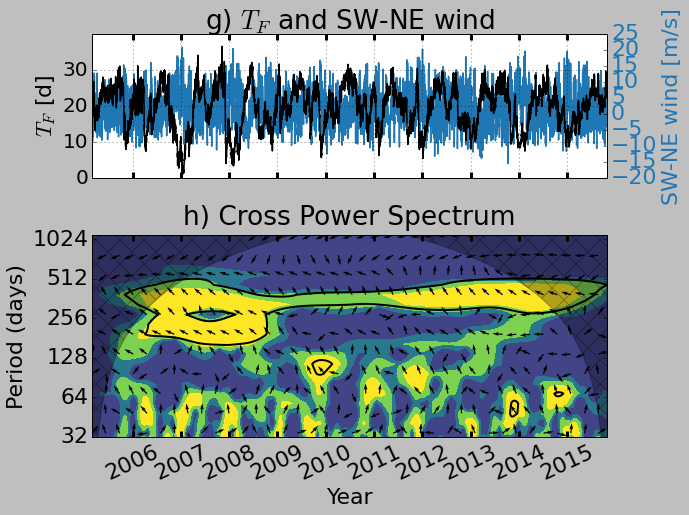

In [22]:
file1 = '../data/TF_DWS.txt'
name1 = '$T_F$ [d]'
title1 = '$T_F$'
file2 = '../data/uwp_tidal.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='a', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

file2 = '../data/vwp_tidal.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/TF_WDWS_x_uwp_tidal.png


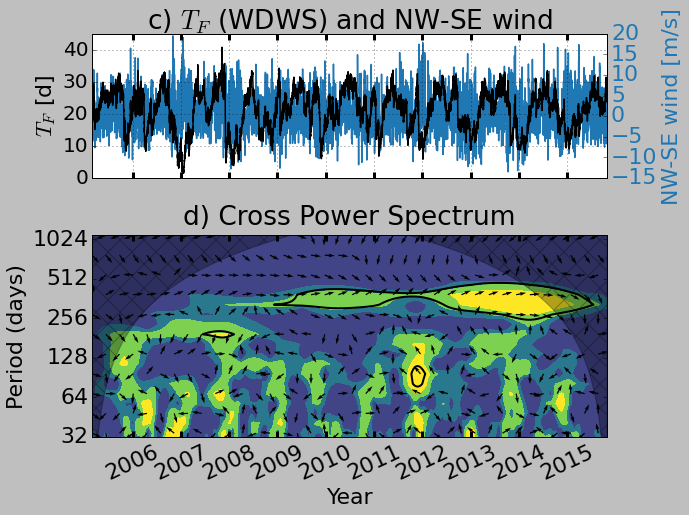

In [23]:
file1 = '../data/TF_WDWS.txt'
name1 = '$T_F$ [d]'
title1 = '$T_F$ (WDWS)'
file2 = '../data/uwp_tidal.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='c', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661


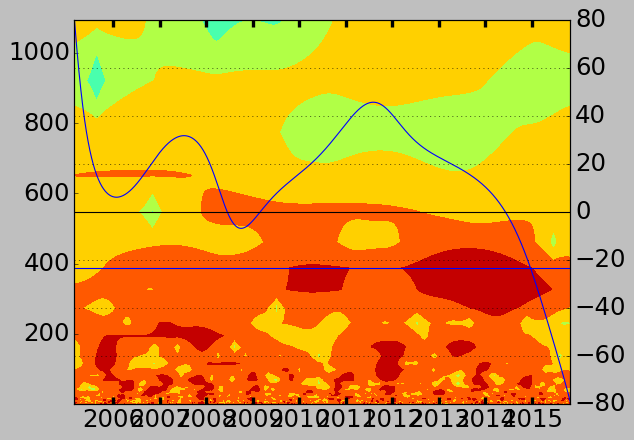

In [24]:
print(resultx['period'][34])
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][34])
ax = plt.twinx()
ax.plot(ts2dates(timestamps), resultx['angles'][34])
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/TF_WDWS_x_vwp_tidal.png


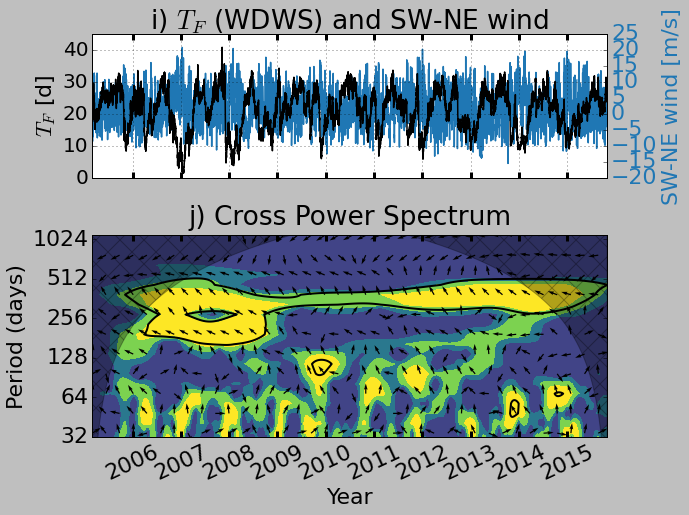

In [25]:
file1 = '../data/TF_WDWS.txt'
name1 = '$T_F$ [d]'
title1 = '$T_F$ (WDWS)'
file2 = '../data/vwp_tidal.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='i', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

193.5459057883305


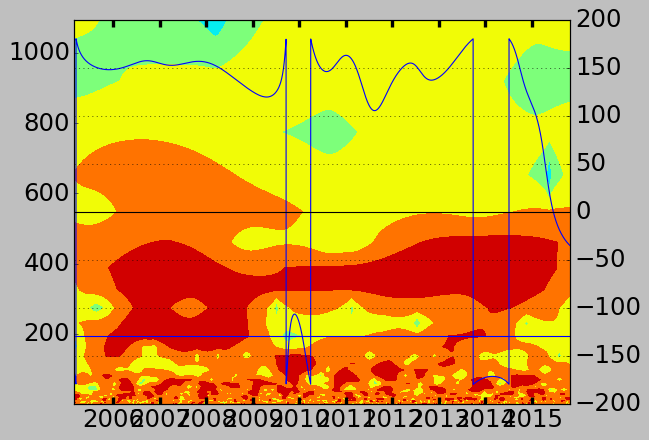

In [26]:
print(resultx['period'][30])
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps), resultx['angles'][30])
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/TF_EDWS_x_uwp_tidal.png


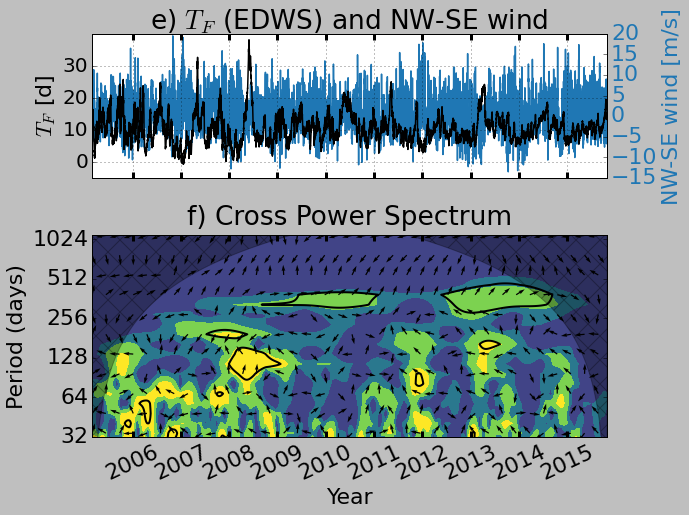

In [27]:
file1 = '../data/TF_EDWS.txt'
name1 = '$T_F$ [d]'
title1 = '$T_F$ (EDWS)'
file2 = '../data/uwp_tidal.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='e', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

115.08308412156444
105.96592428108764 109.05616015147675


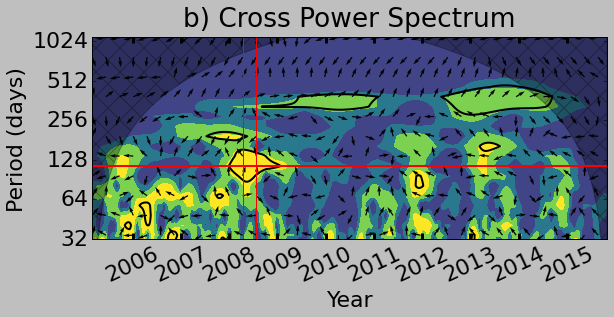

In [28]:
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

ts = ts2dates(timestamps).astype('datetime64[ns]')
dts = int(np.diff(timestamps)[0])

bx = plt.axes([0.1, 0.3, 0.65, 0.35], sharex=ax)
levels = [0.0625, 0.125, 0.25]
bx.contourf(ts, np.log2(resultx['period']), np.log2(np.abs(resultx['W12'])), np.log2(levels), extend='both', cmap=new_cmap)
extent = [ts.min(), ts.max(), 0, max(resultx['period'])]
bx.contour(ts, np.log2(resultx['period']), resultx['sig95'], [-99, 1], colors='k', linewidths=2, extent=extent)
x,y = np.meshgrid(ts[::int(200/(dt/(12.42/24)))], resultx['period'][::2])
ux = yx = np.ones_like(x.astype('float64'))
bx.quiver(x, np.log2(y), ux, yx, angles=resultx['angles'][::2,::int(200/(dt/(12.42/24)))])
bx.set_title('b) Cross Power Spectrum', y=1.03)
bx.set_ylabel('Period (days)')

bx.fill(np.concatenate([ts, ts[-1:] + dts, ts[-1:] + dts,
                           ts[:1] - dts, ts[:1] - dts]),
        np.concatenate([np.log2(resultx['coi']), [1e-9], np.log2(resultx['period'][-1:]),
                           np.log2(resultx['period'][-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_ylim(np.log2([32, resultx['period'].max()]))
Yticks = 2 ** np.arange(np.ceil(np.log2(32)),
                           np.ceil(np.log2(resultx['period'].max()))).astype('int64')
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xlabel('Year')
plt.setp(bx.get_xticklabels(), rotation=25)

print(resultx['period'][27])
print(resultx['angles'][27][2200:2400].min(), resultx['angles'][27][2200:2400].max())
bx.axhline(np.log2(resultx['period'][27]), color='r', linewidth=2)
bx.axvline(ts2dates(timestamps)[2200], color='r')
bx.axvline(ts2dates(timestamps)[2400], color='r')
plt.show()

387.091811576661


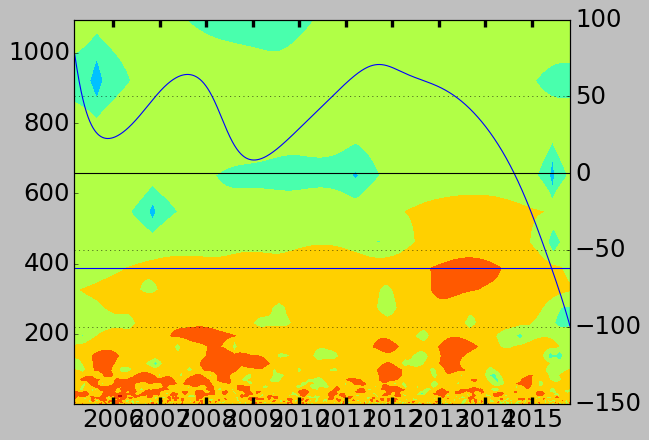

In [29]:
print(resultx['period'][34])
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][34])
ax = plt.twinx()
ax.plot(ts2dates(timestamps), resultx['angles'][34])
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/TF_EDWS_x_vwp_tidal.png


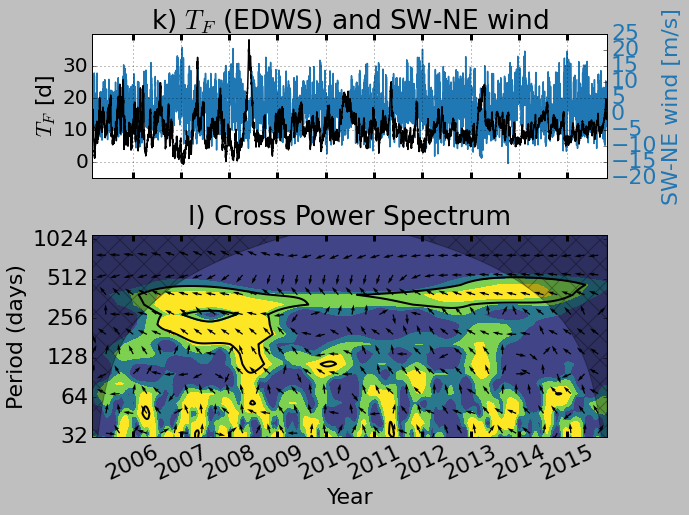

In [30]:
file1 = '../data/TF_EDWS.txt'
name1 = '$T_F$ [d]'
title1 = '$T_F$ (EDWS)'
file2 = '../data/vwp_tidal.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/timeline.txt')

dt = 12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 10 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

136.85762245382114
110.98148403380331 123.94810545537402


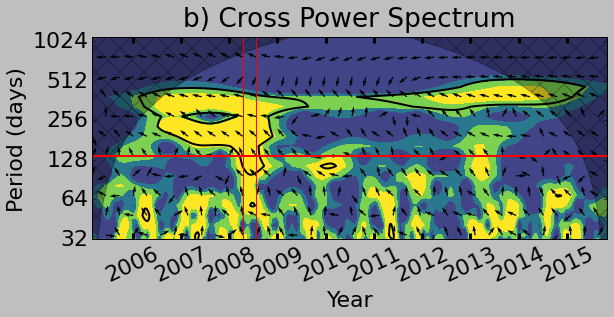

In [31]:
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

ts = ts2dates(timestamps).astype('datetime64[ns]')
dts = int(np.diff(timestamps)[0])

bx = plt.axes([0.1, 0.3, 0.65, 0.35], sharex=ax)
levels = [0.0625, 0.125, 0.25]
bx.contourf(ts, np.log2(resultx['period']), np.log2(np.abs(resultx['W12'])), np.log2(levels), extend='both', cmap=new_cmap)
extent = [ts.min(), ts.max(), 0, max(resultx['period'])]
bx.contour(ts, np.log2(resultx['period']), resultx['sig95'], [-99, 1], colors='k', linewidths=2, extent=extent)
x,y = np.meshgrid(ts[::int(200/(dt/(12.42/24)))], resultx['period'][::2])
ux = yx = np.ones_like(x.astype('float64'))
bx.quiver(x, np.log2(y), ux, yx, angles=resultx['angles'][::2,::int(200/(dt/(12.42/24)))])
bx.set_title('b) Cross Power Spectrum', y=1.03)
bx.set_ylabel('Period (days)')

bx.fill(np.concatenate([ts, ts[-1:] + dts, ts[-1:] + dts,
                           ts[:1] - dts, ts[:1] - dts]),
        np.concatenate([np.log2(resultx['coi']), [1e-9], np.log2(resultx['period'][-1:]),
                           np.log2(resultx['period'][-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_ylim(np.log2([32, resultx['period'].max()]))
Yticks = 2 ** np.arange(np.ceil(np.log2(32)),
                           np.ceil(np.log2(resultx['period'].max()))).astype('int64')
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xlabel('Year')
plt.setp(bx.get_xticklabels(), rotation=25)

print(resultx['period'][28])
print(resultx['angles'][28][2200:2400].min(), resultx['angles'][28][2200:2400].max())
bx.axhline(np.log2(resultx['period'][28]), color='r', linewidth=2)
bx.axvline(ts2dates(timestamps)[2200], color='r')
bx.axvline(ts2dates(timestamps)[2400], color='r')
#cx = plt.twinx()
#cx.plot(ts2dates(timestamps)[2200:2500], resultx['angles'][28][2200:2500], 'r')
plt.show()

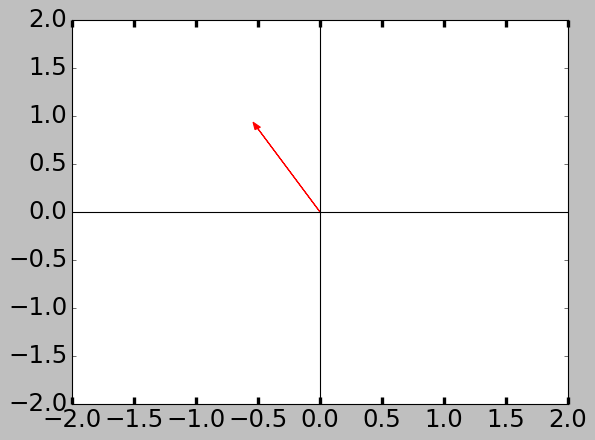

In [32]:
theta = 120 *np.pi/180
x = np.cos(theta)
y = np.sin(theta)

plt.arrow(0,0,x,y, head_width=0.05, color='r')
plt.axis([-2,2,-2,2])
plt.gca().axhline(0, color='k')
plt.gca().axvline(0, color='k')

136.85762245382114
110.98148403380331 123.94810545537402


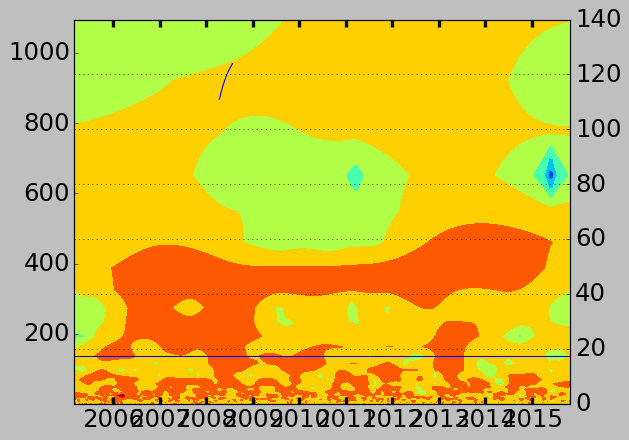

In [33]:
print(resultx['period'][28])
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][28])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[2200:2400], resultx['angles'][28][2200:2400])
print(resultx['angles'][28][2200:2400].min(), resultx['angles'][28][2200:2400].max())
ax.axhline(0, color='k')
ax.grid()

<ipython-input-34-ed78dfce8ab9>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.plot(ts2dates(timestamps[[resultx['sig95'][34]>1]]), angles[34][resultx['sig95'][34]>1],
<ipython-input-34-ed78dfce8ab9>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.plot(ts2dates(timestamps[[resultx['sig95'][30]>1]]), angles[30][resultx['sig95'][30]>1],


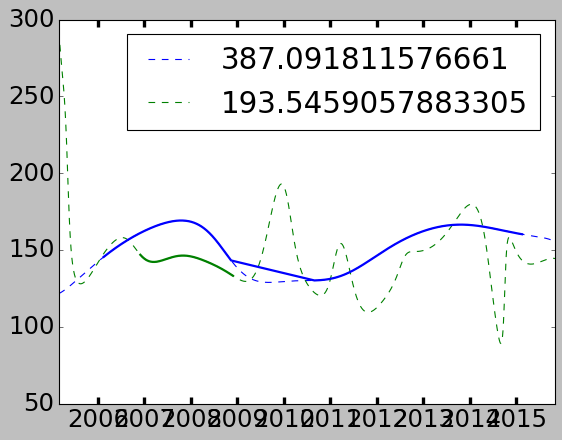

In [34]:
angles = copy.deepcopy(resultx['angles'])
angles[angles<0] += 360
plt.plot(ts2dates(timestamps), angles[34], 'b--', label=str(resultx['period'][34]))
plt.plot(ts2dates(timestamps[[resultx['sig95'][34]>1]]), angles[34][resultx['sig95'][34]>1], 
         'b', linewidth=2, zorder=10)
plt.plot(ts2dates(timestamps), angles[30], 'g--', label=str(resultx['period'][30]))
plt.plot(ts2dates(timestamps[[resultx['sig95'][30]>1]]), angles[30][resultx['sig95'][30]>1], 
         'g', linewidth=2, zorder=10)

plt.legend()
plt.show()

# Residence time

Figure saved as ../figures/pycwt/RTmean.png


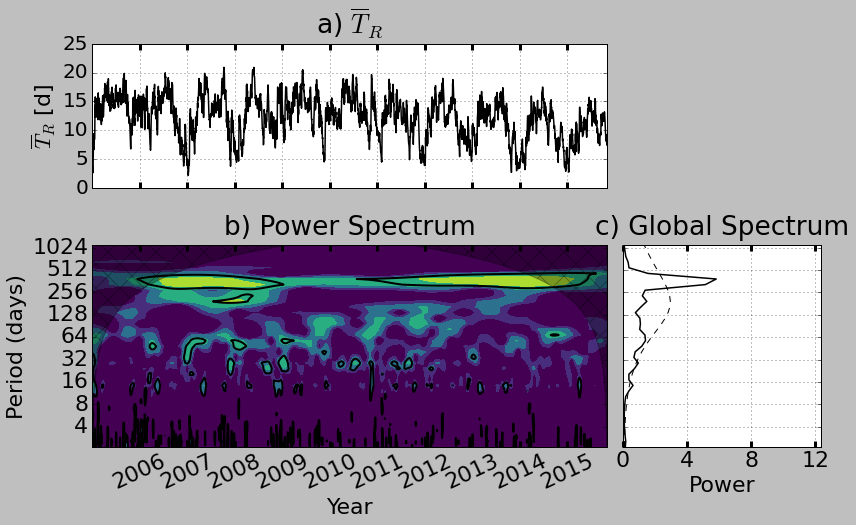

In [35]:
file = '../data/RTmean.txt'
name = '$\overline{T}_R$ [d]'
title = '$\overline{T}_R$'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/RTWDWSmean.png


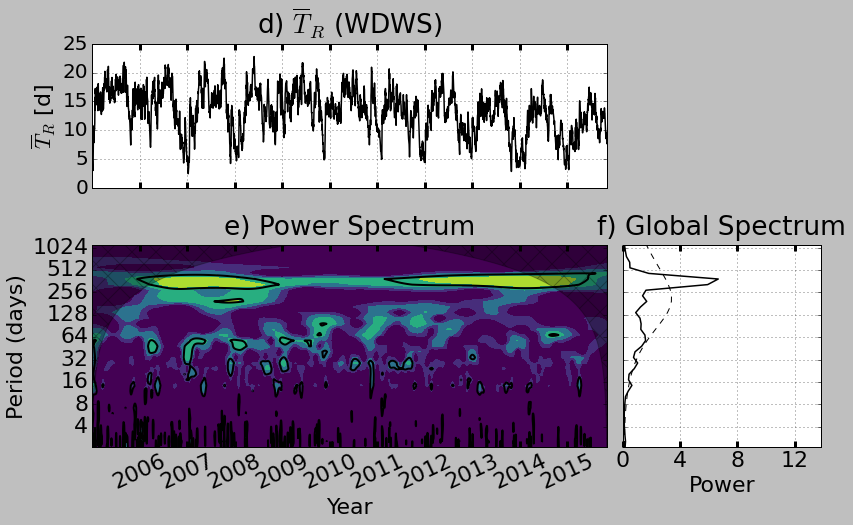

In [36]:
file = '../data/RTWDWSmean.txt'
name = '$\overline{T}_R$ [d]'
title = '$\overline{T}_R$ (WDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='d', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/RTEDWSmean.png


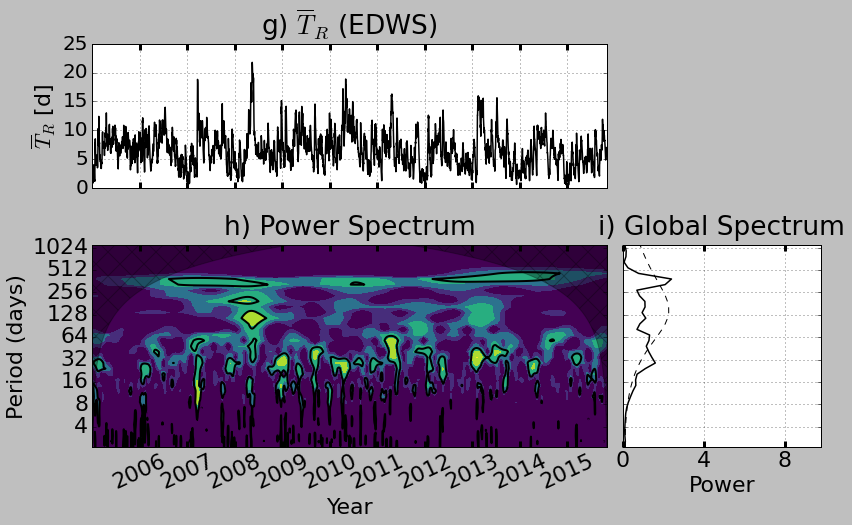

In [37]:
file = '../data/RTEDWSmean.txt'
name = '$\overline{T}_R$ [d]'
title = '$\overline{T}_R$ (EDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='g', path='../figures/pycwt/{}.png'.format(file[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RTmean_x_uwp_dep.png


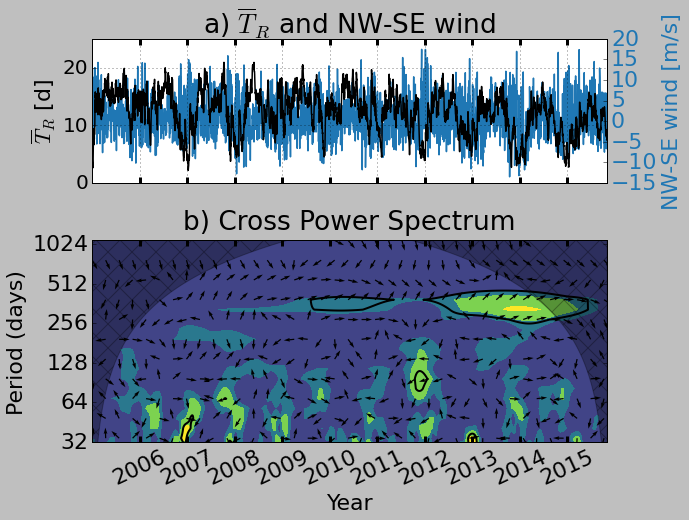

In [38]:
file1 = '../data/RTmean.txt'
name1 = '$\overline{T}_R$ [d]'
title1 = '$\overline{T}_R$'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='a', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661
23.112093242376584 60.871239976622796


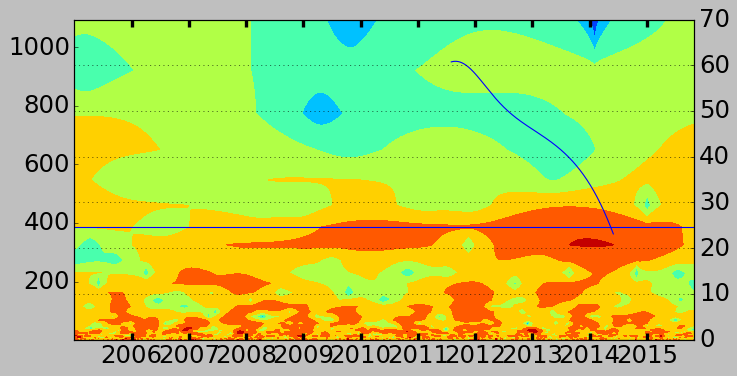

In [39]:
print(resultx['period'][30])
plt.figure(figsize=(10,5))
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[-1500:-500], resultx['angles'][30][-1500:-500])
print(resultx['angles'][30][-1500:-500].min(), resultx['angles'][30][-1500:-500].max())
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RTmean_x_vwp_dep.png


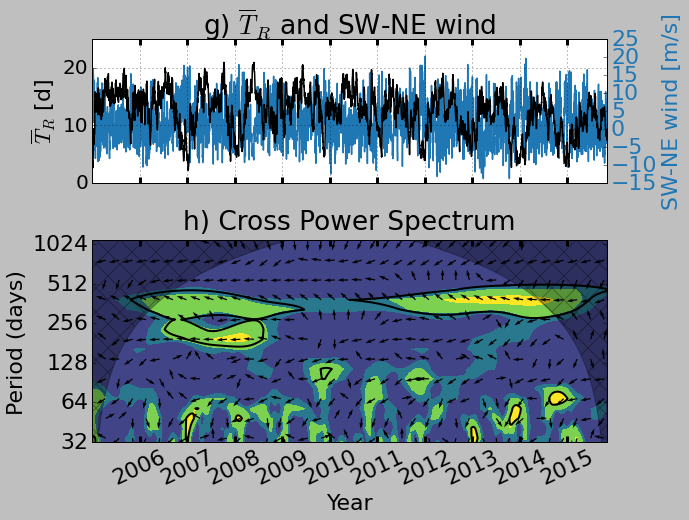

In [40]:
file1 = '../data/RTmean.txt'
name1 = '$\overline{T}_R$ [d]'
title1 = '$\overline{T}_R$'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661
135.14512822780455 176.3037335705717


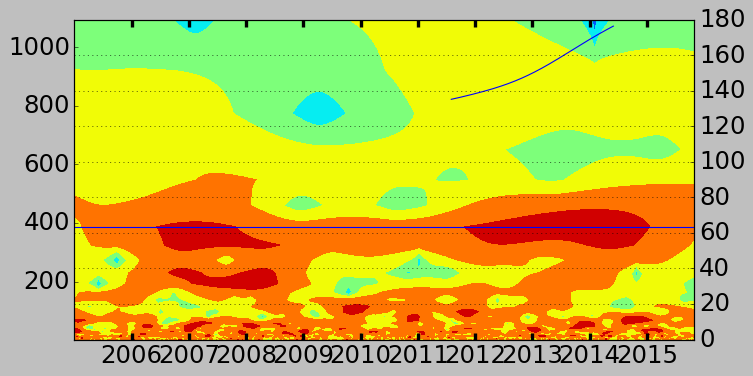

In [41]:
print(resultx['period'][30])
plt.figure(figsize=(10,5))
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[-1500:-500], resultx['angles'][30][-1500:-500])
print(resultx['angles'][30][-1500:-500].min(), resultx['angles'][30][-1500:-500].max())
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RTWDWSmean_x_uwp_dep.png


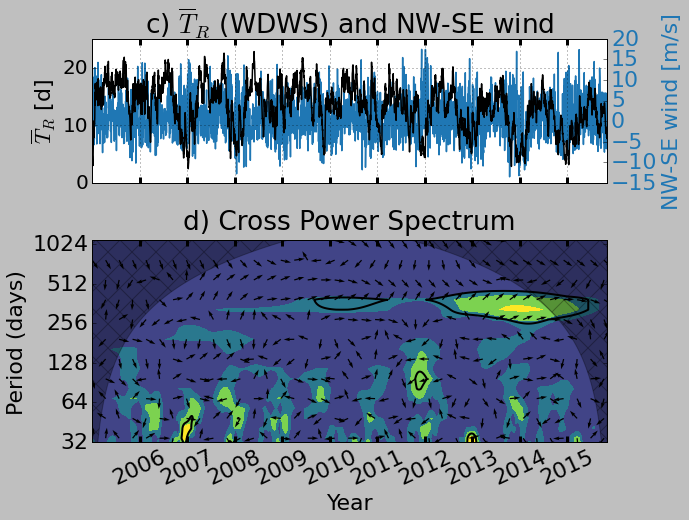

In [42]:
file1 = '../data/RTWDWSmean.txt'
name1 = '$\overline{T}_R$ [d]'
title1 = '$\overline{T}_R$ (WDWS)'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='c', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661
23.213118149215656 59.14111658587498


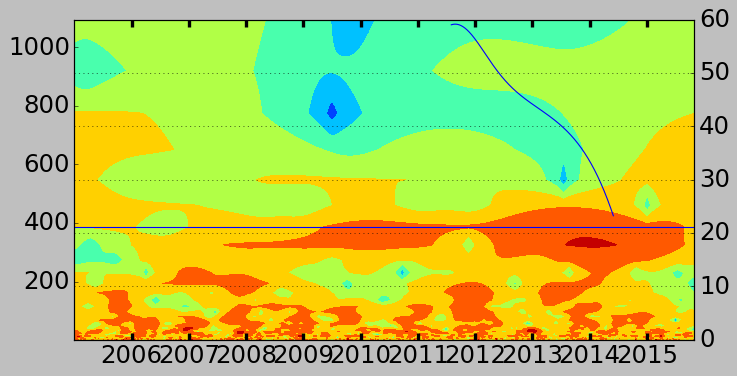

In [43]:
print(resultx['period'][30])
plt.figure(figsize=(10,5))
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[-1500:-500], resultx['angles'][30][-1500:-500])
print(resultx['angles'][30][-1500:-500].min(), resultx['angles'][30][-1500:-500].max())
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RTWDWSmean_x_vwp_dep.png


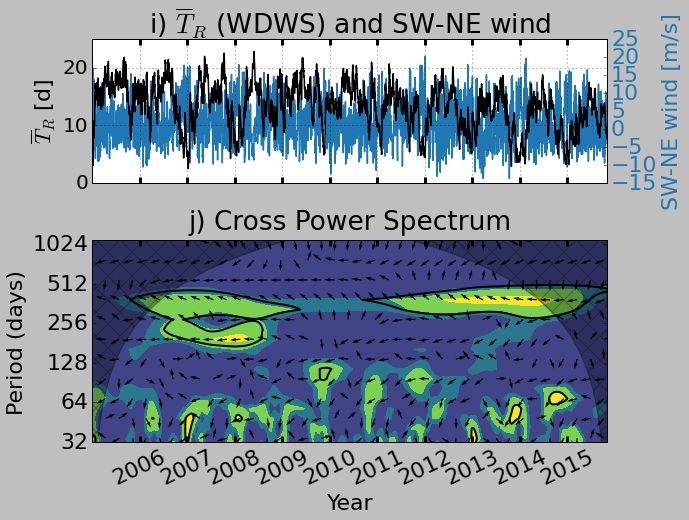

In [44]:
file1 = '../data/RTWDWSmean.txt'
name1 = '$\overline{T}_R$ [d]'
title1 = '$\overline{T}_R$ (WDWS)'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='i', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661
133.42616811475446 176.40475847741072


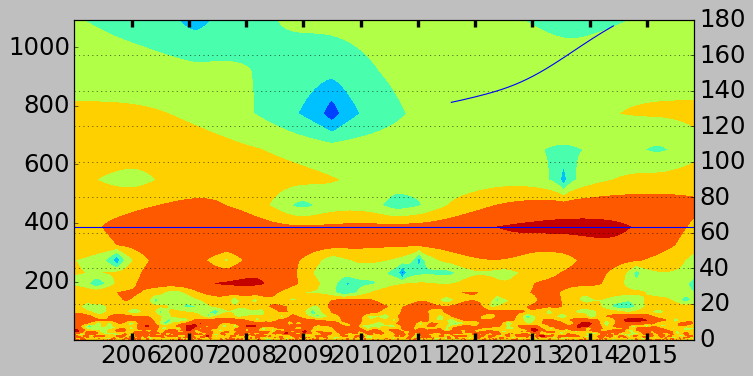

In [45]:
print(resultx['period'][30])
plt.figure(figsize=(10,5))
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[-1500:-500], resultx['angles'][30][-1500:-500])
print(resultx['angles'][30][-1500:-500].min(), resultx['angles'][30][-1500:-500].max())
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RTEDWSmean_x_uwp_dep.png


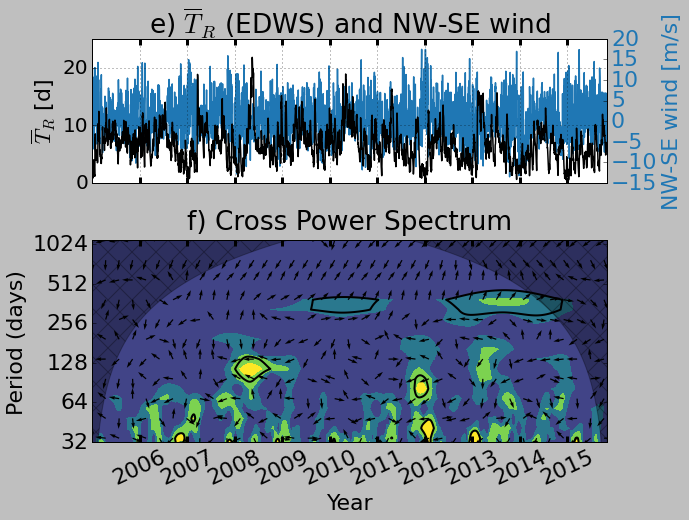

In [46]:
file1 = '../data/RTEDWSmean.txt'
name1 = '$\overline{T}_R$ [d]'
title1 = '$\overline{T}_R$ (EDWS)'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='e', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661
22.53637050074604 81.18984233500927


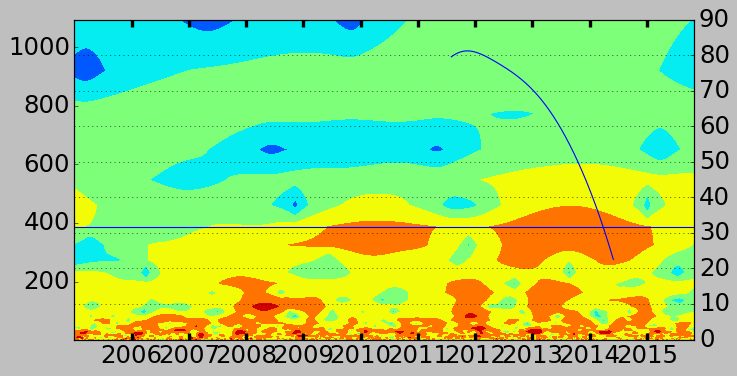

In [47]:
print(resultx['period'][30])
plt.figure(figsize=(10,5))
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[-1500:-500], resultx['angles'][30][-1500:-500])
print(resultx['angles'][30][-1500:-500].min(), resultx['angles'][30][-1500:-500].max())
ax.axhline(0, color='k')
ax.grid()

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RTEDWSmean_x_vwp_dep.png


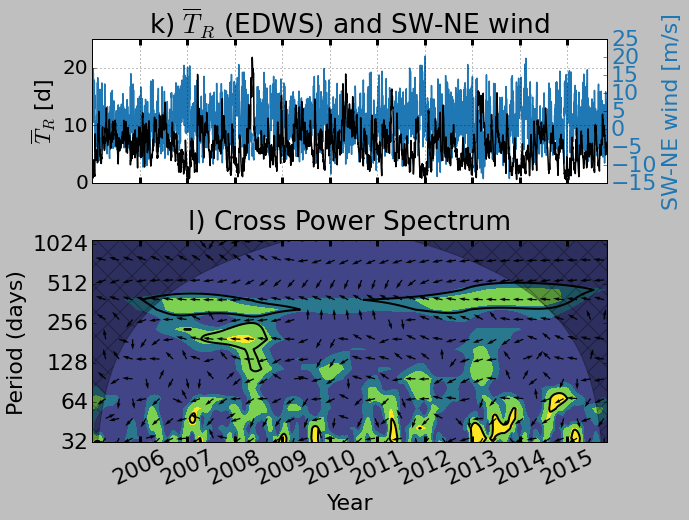

In [48]:
file1 = '../data/RTEDWSmean.txt'
name1 = '$\overline{T}_R$ [d]'
title1 = '$\overline{T}_R$ (EDWS)'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

387.091811576661
153.9177930473528 177.18612640449192


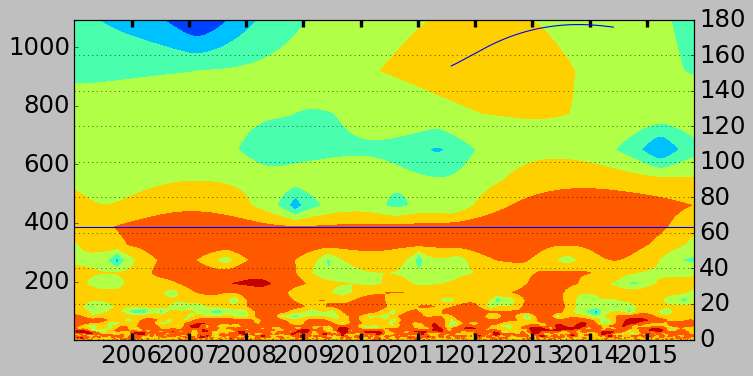

In [49]:
print(resultx['period'][30])
plt.figure(figsize=(10,5))
plt.contourf(ts2dates(timestamps), resultx['period'], np.log2(np.abs(resultx['W12'])))
plt.gca().axhline(resultx['period'][30])
ax = plt.twinx()
ax.plot(ts2dates(timestamps)[-1500:-500], resultx['angles'][30][-1500:-500])
print(resultx['angles'][30][-1500:-500].min(), resultx['angles'][30][-1500:-500].max())
ax.axhline(0, color='k')
ax.grid()

# Exposure time

Figure saved as ../figures/pycwt/ETmean.png


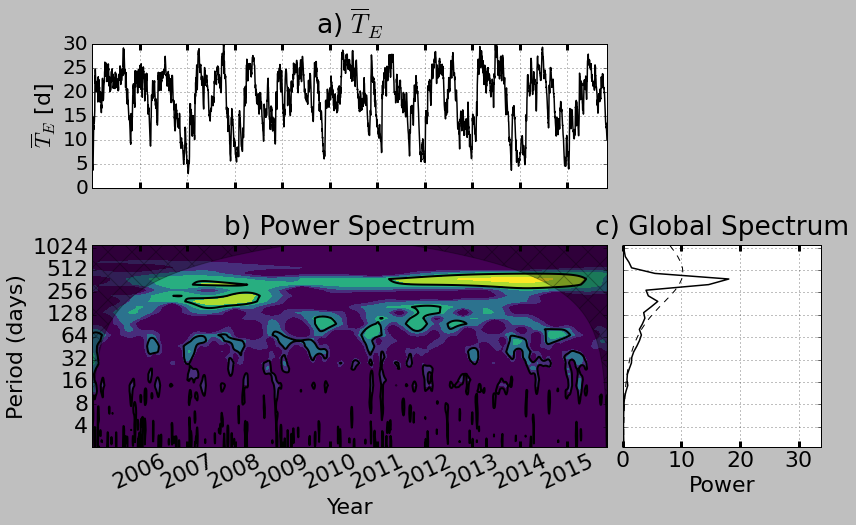

In [50]:
file = '../data/ETmean.txt'
name = '$\overline{T}_E$ [d]'
title = '$\overline{T}_E$'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/ETWDWSmean.png


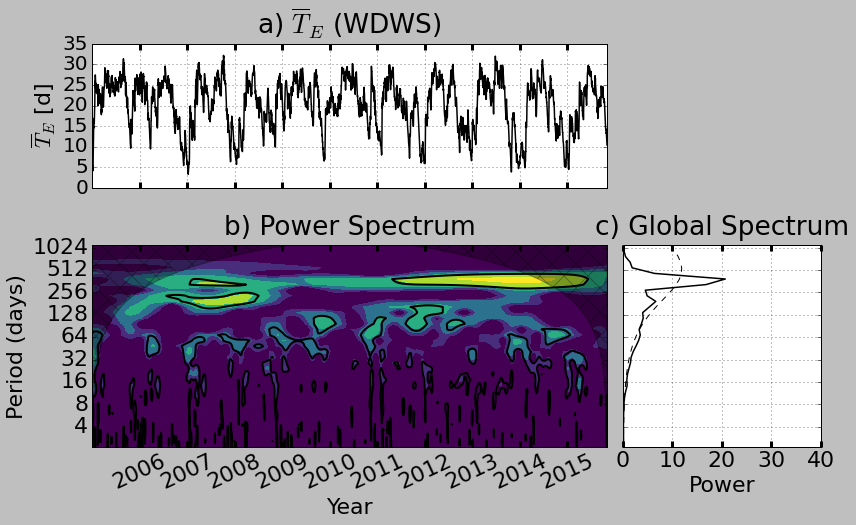

In [51]:
file = '../data/ETWDWSmean.txt'
name = '$\overline{T}_E$ [d]'
title = '$\overline{T}_E$ (WDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/ETEDWSmean.png


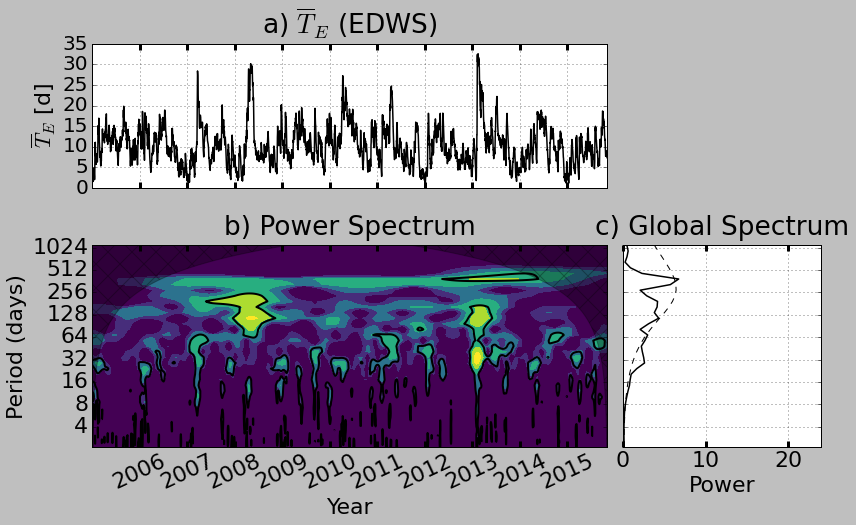

In [52]:
file = '../data/ETEDWSmean.txt'
name = '$\overline{T}_E$ [d]'
title = '$\overline{T}_E$ (EDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/ETmean_x_uwp_dep.png


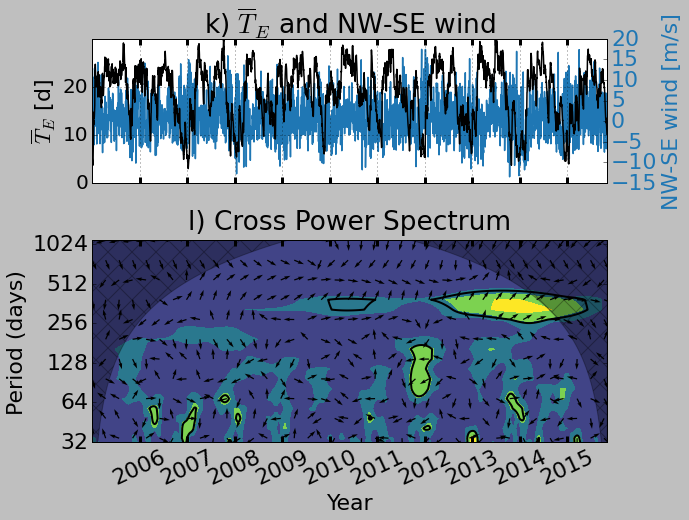

In [53]:
file1 = '../data/ETmean.txt'
name1 = '$\overline{T}_E$ [d]'
title1 = '$\overline{T}_E$'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/ETmean_x_vwp_dep.png


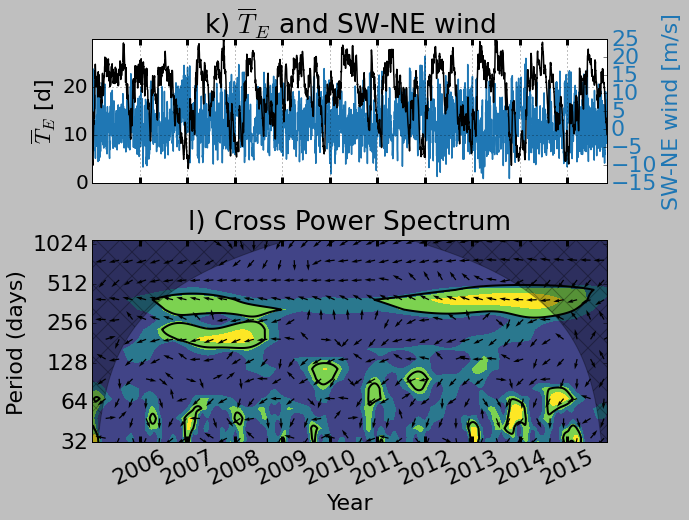

In [54]:
file1 = '../data/ETmean.txt'
name1 = '$\overline{T}_E$ [d]'
title1 = '$\overline{T}_E$'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/ETWDWSmean_x_uwp_dep.png


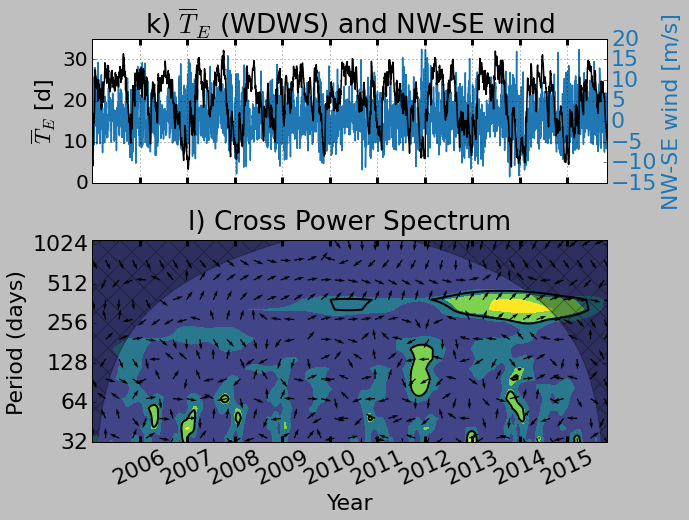

In [55]:
file1 = '../data/ETWDWSmean.txt'
name1 = '$\overline{T}_E$ [d]'
title1 = '$\overline{T}_E$ (WDWS)'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/ETWDWSmean_x_vwp_dep.png


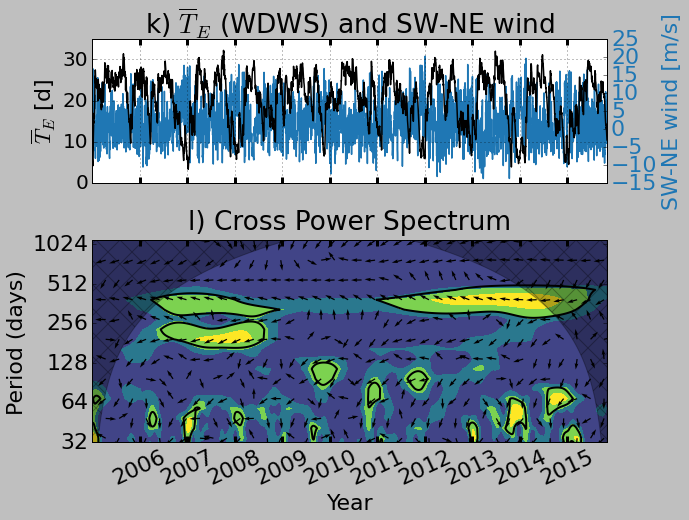

In [56]:
file1 = '../data/ETWDWSmean.txt'
name1 = '$\overline{T}_E$ [d]'
title1 = '$\overline{T}_E$ (WDWS)'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/ETEDWSmean_x_uwp_dep.png


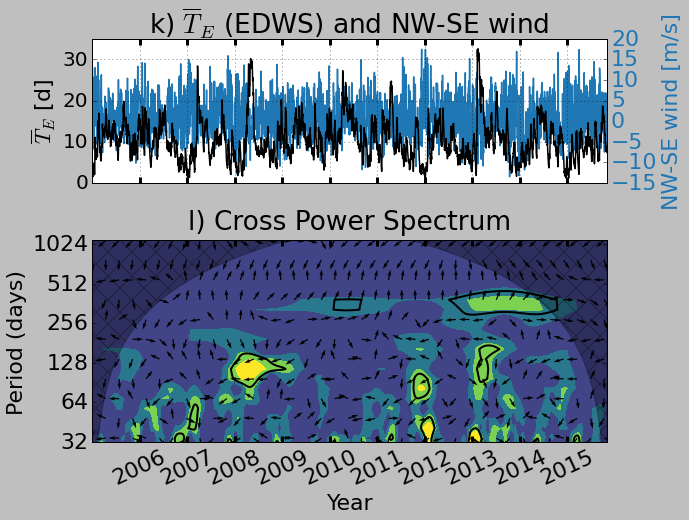

In [57]:
file1 = '../data/ETEDWSmean.txt'
name1 = '$\overline{T}_E$ [d]'
title1 = '$\overline{T}_E$ (EDWS)'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/ETEDWSmean_x_vwp_dep.png


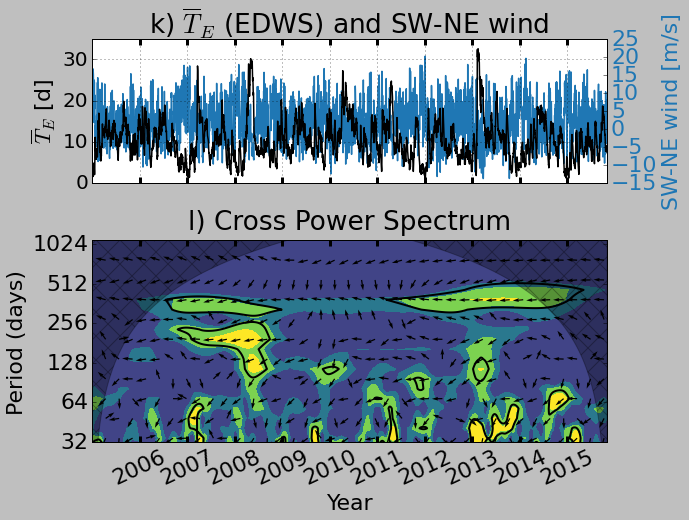

In [58]:
file1 = '../data/ETEDWSmean.txt'
name1 = '$\overline{T}_E$ [d]'
title1 = '$\overline{T}_E$ (EDWS)'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='k', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

# Return coefficient

Figure saved as ../figures/pycwt/RC.png


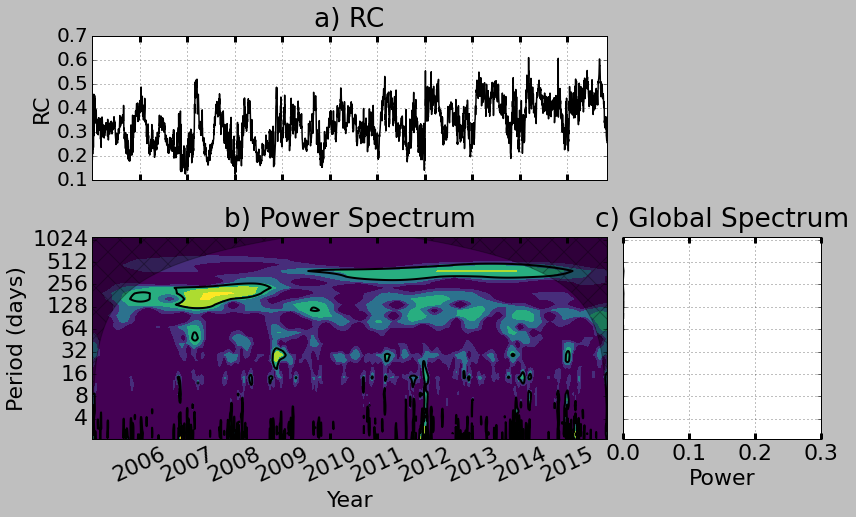

In [59]:
file = '../data/RC.txt'
name = 'RC'
title = 'RC'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/RCWDWS.png


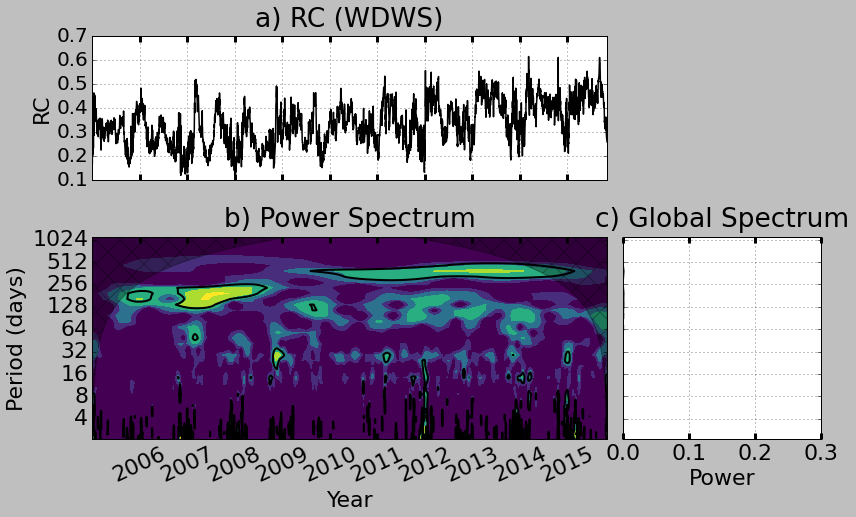

In [60]:
file = '../data/RCWDWS.txt'
name = 'RC'
title = 'RC (WDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

Figure saved as ../figures/pycwt/RCEDWS.png


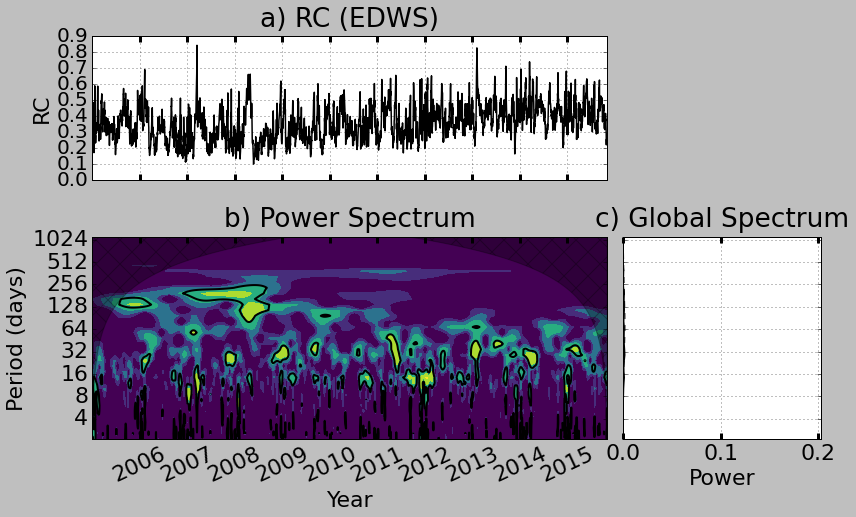

In [61]:
file = '../data/RCEDWS.txt'
name = 'RC'
title = 'RC (EDWS)'
dat = np.loadtxt(file)
N = dat.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

result = get_wavelet(t, dt, dat, mother, s0, dj, J, alpha, name, title)
plot_wavelet(timestamps, result, char='a', path='../figures/pycwt/{}.png'.format(file[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RC_x_vwp_dep.png


<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RC_x_uwp_dep.png


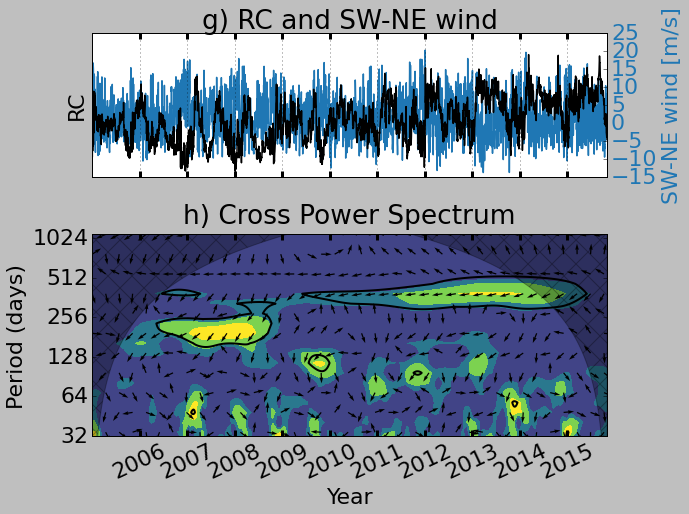

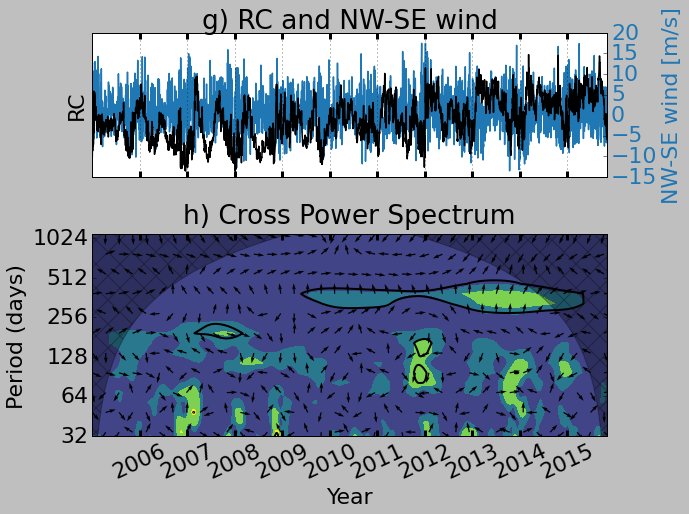

In [62]:
file1 = '../data/RC.txt'
name1 = 'RC'
title1 = 'RC'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

#file1 = '../data/RC.txt'
#name1 = 'RC'
#title1 = 'RC'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RCWDWS_x_vwp_dep.png


<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RCWDWS_x_uwp_dep.png


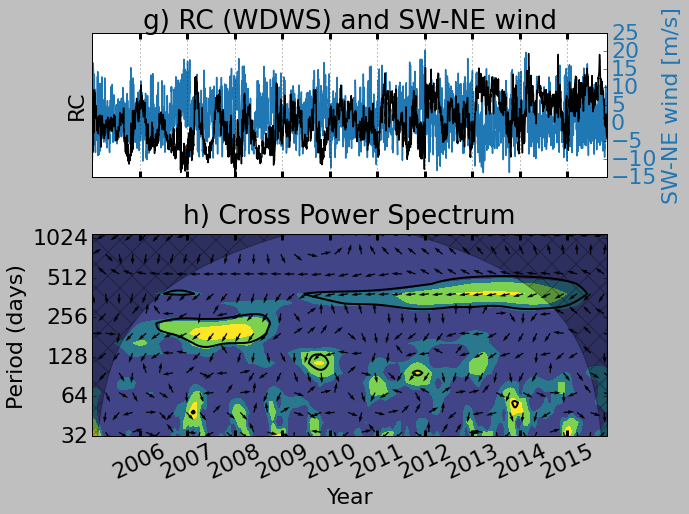

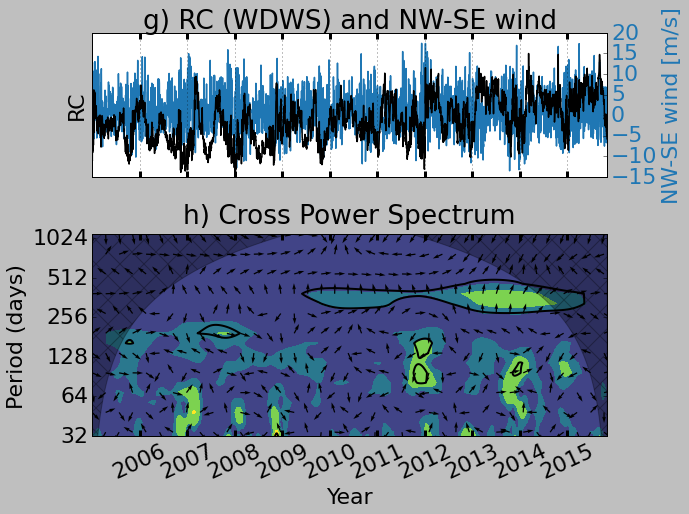

In [63]:
file1 = '../data/RCWDWS.txt'
name1 = 'RC'
title1 = 'RC (WDWS)'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

#file1 = '../data/RC.txt'
#name1 = 'RC'
#title1 = 'RC'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RCEDWS_x_vwp_dep.png


<ipython-input-14-937ee9b3a711>:66: RuntimeWarning: divide by zero encountered in true_divide
  sig95c = WCT / sig95c


Figure saved as ../figures/pycwt/cross_wavelet/RCEDWS_x_uwp_dep.png


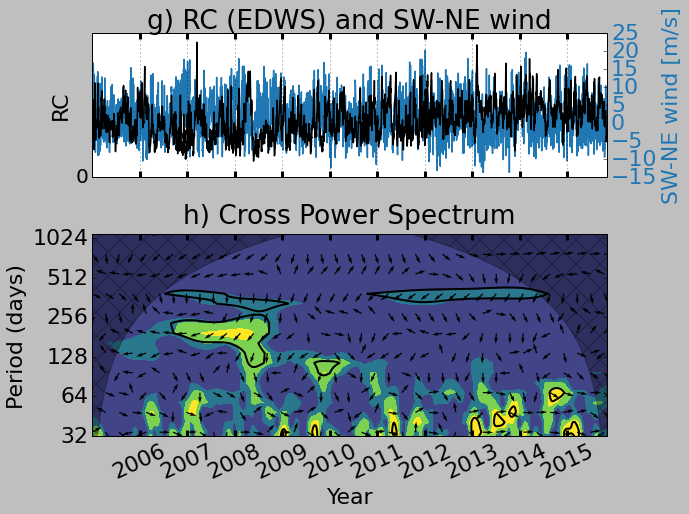

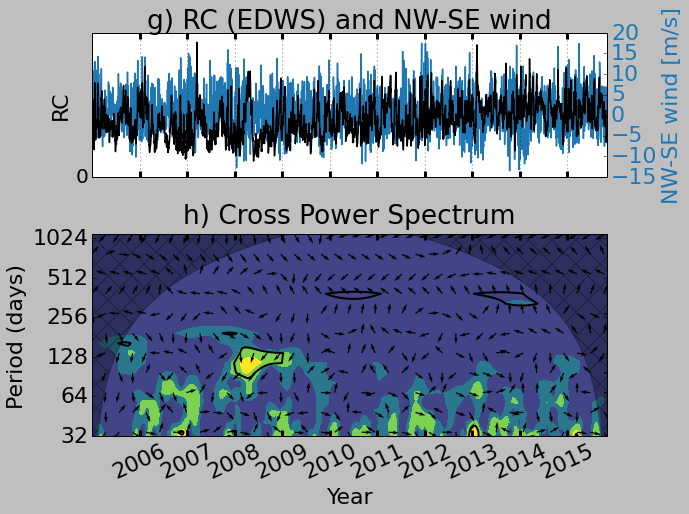

In [64]:
file1 = '../data/RCEDWS.txt'
name1 = 'RC'
title1 = 'RC (EDWS)'
file2 = '../data/vwp_dep.txt'
name2 = 'SW-NE wind [m/s]'
title2 = 'SW-NE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))

#file1 = '../data/RC.txt'
#name1 = 'RC'
#title1 = 'RC'
file2 = '../data/uwp_dep.txt'
name2 = 'NW-SE wind [m/s]'
title2 = 'NW-SE wind'
titlex = title1+' vs. '+title2
namex = name1+'_x_'+name2
dat1 = np.loadtxt(file1)
dat2 = np.loadtxt(file2)
N = dat1.size
timestamps = np.loadtxt('../data/deployment_times.txt')

dt = 2*12.42/24  # in days
t = np.arange(0, N) * dt

#parameters
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 12.42/24 = 24.84 hours
dj = 1 / 4  # 4 sub-octaves per octaves
J = 9 / dj  # eleven powers of two with dj sub-octaves
alpha1, _, _ = wavelet.ar1(dat1)  # Lag-1 autocorrelation for red noise
alpha2, _, _ = wavelet.ar1(dat2)  # Lag-1 autocorrelation for red noise

result1 = get_wavelet(t, dt, dat1, mother, s0, dj, J, alpha1, name1, title1)
result2 = get_wavelet(t, dt, dat2, mother, s0, dj, J, alpha2, name2, title2)
resultx = get_cross_wavelet(result1, result2, namex, titlex)

plot_cross_wavelet(timestamps, result1, result2, resultx, char='g', path='../figures/pycwt/cross_wavelet/{}_x_{}.png'.format(file1[8:-4], file2[8:-4]))